In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

import scTRS.util as util
import scTRS.method as md
import scTRS.data_loader as dl
import submitit
import numpy as np
from anndata import read_h5ad
from statsmodels.stats.multitest import multipletests

import pandas as pd
import os
from os.path import join
import itertools
import pickle
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt

# constants
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
SCORE_FILE_DIR = join(DATA_PATH, "score_file")

TRAIT_LIST = ['PASS_Schizophrenia_Ruderfer2018',
              'PASS_BipolarDisorder_Ruderfer2018',
              'PASS_Alzheimers_Jansen2019', 
              'PASS_AdultOnsetAsthma_Ferreira2019',
              'PASS_Coronary_Artery_Disease', 
              'PASS_LargeArteryStroke_Malik2018', 
              'PASS_HDL', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_Lupus', 
              'PASS_FastingGlucose_Manning',
              'PASS_IBD_deLange2017', 
              'PASS_Type_1_Diabetes', 
              'PASS_Type_2_Diabetes']

SCORE_ADATA = read_h5ad("/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/tabula_muris_senis/tabula-muris-senis-facs-official-raw-obj.h5ad")
md.compute_stats(SCORE_ADATA)
PLOT_ADATA_DICT = dl.load_tms_processed('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data', data_name='facs', tissue='all')

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/scipy/sparse/data.py:133: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/scipy/sparse/data.py:117: RuntimeWarning: overflow encountered in square
  return self._with_data(data ** n)
/n/home12/khou/scTRS/scTRS/method.py:394: RuntimeWarning: overflow encountered in square
  v_var = v_var - v_mean**2
/n/home12/khou/scTRS/scTRS/method.py:394: RuntimeWarning: invalid value encountered in subtract
  v_var = v_var - v_mean**2


# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [2]:
result_dir = join(SCORE_FILE_DIR, "score.facs.gwas_max_abs_z.top500")
result_dict = {}
for trait in TRAIT_LIST:
    result_dict[trait] = pd.read_csv(join(result_dir, f"{trait}.score.gz"), sep='\t')
    
# add random traits result
result_dir = join(SCORE_FILE_DIR, "score.facs.all_size500.weight_1en2")
for rep_i in range(5):
    result_dict[f"random_{rep_i}"] = pd.read_csv(join(result_dir, f"all_size500_rep{rep_i}.score.gz"), sep='\t')

In [4]:
zsc_dict = {trait: result_dict[trait].zscore.values for trait in result_dict}
zsc_index = result_dict[trait]['index'].values
# For each trait, calculate the mean, sd, geary's C statistics for each tissue - celltype pair
# and priotorize
trs_stats = util.calculate_trs_stats(zsc_dict=zsc_dict, zsc_index=zsc_index, 
                                stats_dict = {"mean": np.mean, "sd": np.std, "gearysc": None},
                                adata=PLOT_ADATA_DICT["Liver"], stratify_by="cell_ontology_class")
trs_stats["gearysc"]

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,PASS_Schizophrenia_Ruderfer2018,PASS_BipolarDisorder_Ruderfer2018,PASS_Alzheimers_Jansen2019,PASS_AdultOnsetAsthma_Ferreira2019,PASS_Coronary_Artery_Disease,PASS_LargeArteryStroke_Malik2018,PASS_HDL,PASS_LDL,PASS_Rheumatoid_Arthritis,PASS_Lupus,PASS_FastingGlucose_Manning,PASS_IBD_deLange2017,PASS_Type_1_Diabetes,PASS_Type_2_Diabetes,random_0,random_1,random_2,random_3,random_4
B cell,1.039177,1.011243,0.979463,0.974678,1.001037,1.011770,0.875911,0.928213,0.905037,0.905279,0.985546,0.836450,0.938148,0.973006,0.973288,1.006356,1.005880,0.949516,1.007180
"CD4-positive, alpha-beta T cell",0.871667,0.972955,0.709344,0.876888,1.107593,0.781877,1.027696,0.868170,0.877461,0.986549,1.103031,1.092697,1.272804,1.021770,1.220331,0.859227,1.306894,1.164752,0.764184
"CD8-positive, alpha-beta T cell",0.995675,1.052394,1.050777,0.867412,0.821725,0.938052,0.891429,0.917746,0.819606,0.870697,0.921228,0.908596,0.756259,1.001931,1.205003,0.661051,0.948431,0.874247,0.907622
Kupffer cell,0.928977,0.890426,0.875614,0.903162,0.876805,0.916874,0.714575,0.794043,0.846783,0.878217,0.928325,0.816240,0.902863,0.887560,0.962200,0.857843,0.996268,0.977885,1.012036
NK cell,1.101968,0.814428,0.758948,0.988263,0.955194,0.998032,0.803135,0.453476,0.853145,0.886271,0.824517,0.939479,0.662274,1.112459,0.758690,0.953007,0.904927,0.809062,0.972399
T cell,0.879025,0.851979,0.943573,0.948879,1.229783,0.844868,1.117060,1.190418,0.857672,0.952504,0.844030,0.650352,1.028485,0.949988,0.976220,1.195120,0.950427,1.303049,1.168842
endothelial cell of hepatic sinusoid,0.961888,0.945343,0.923408,0.928275,0.969067,0.974004,0.927573,1.008562,0.940645,0.849935,0.906483,0.941400,0.875595,0.884296,0.996263,0.984006,0.979057,0.964370,0.980398
hepatocyte,0.677828,0.620227,0.769177,0.745060,0.513472,0.691732,0.381349,0.315428,0.524034,0.769281,0.586936,0.667161,0.458084,0.670650,0.878811,0.791727,0.722965,0.617389,0.937116
mature NK T cell,1.038774,0.918424,0.898978,0.950493,0.977961,0.888286,0.918966,0.939835,0.710834,0.862725,0.896500,0.793074,0.911399,1.003301,1.047958,0.983432,0.959366,0.871799,0.978224
myeloid leukocyte,0.936260,0.937924,0.870291,0.919832,0.857500,0.769296,0.810039,0.789848,0.987310,0.830174,0.881662,0.905229,0.893031,0.923296,0.917836,0.927021,0.806406,0.948365,1.011219


# Use negative controls to determine significance

# Use ctrl_raw_score / ctrl_norm_score

raw


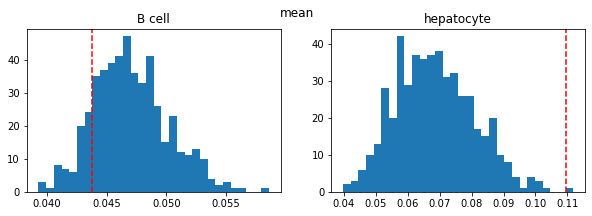

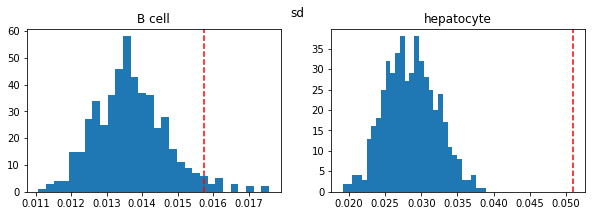

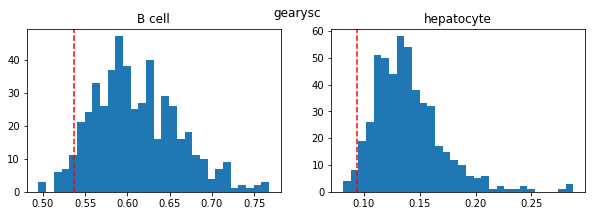

norm


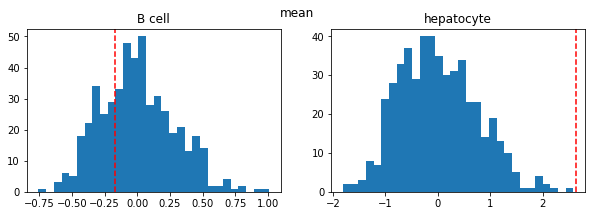

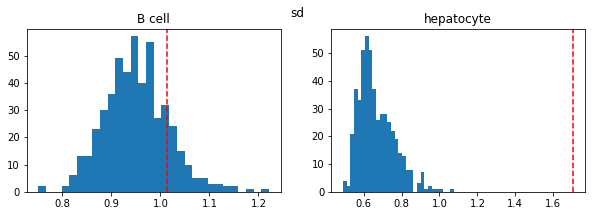

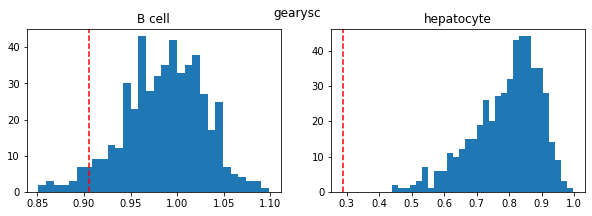

In [20]:
# trait = "PASS_LDL"
ctrl_zsc = pd.read_csv(join(SCORE_FILE_DIR, "score.facs.gwas_max_abs_z.top500", f"{trait}.full_score.gz"), sep='\t', index_col=0)

for prefix in ["raw", "norm"]:
    print(prefix)
    trait_col = f"{prefix}_score"
    ctrl_cols = [col for col in ctrl_zsc.columns if col.startswith(f"ctrl_{prefix}_score_")]

    tissue = "Liver"
    tissue_index = SCORE_ADATA.obs.index[SCORE_ADATA.obs.tissue == tissue]
    tissue_ctrl_zsc = ctrl_zsc.loc[tissue_index, :]

    zsc_dict = dict()
    zsc_dict[trait_col] = tissue_ctrl_zsc[trait_col]
    for col in ctrl_cols:
        zsc_dict[col] = tissue_ctrl_z1sc[col]

    zsc_index = tissue_index
    trs_stats = util.calculate_trs_stats(zsc_dict=zsc_dict, zsc_index=zsc_index, 
                                    stats_dict = {"mean": np.mean, "sd": np.std, "gearysc": None},
                                    adata=PLOT_ADATA_DICT[tissue], stratify_by="cell_ontology_class")

    ct_list = ["B cell", "hepatocyte"]
    for name in ["mean", "sd", "gearysc"]:
        plt.figure(figsize=(10, 3))
        for ct_i, ct in enumerate(ct_list):
            plt.subplot(1, len(ct_list), ct_i + 1)
            plt.hist(trs_stats[name].loc[ct, ctrl_cols], 30)
            plt.axvline(trs_stats[name].loc[ct, trait_col], ls="--", color="red")
            plt.title(ct)
        plt.suptitle(name)
        plt.show()

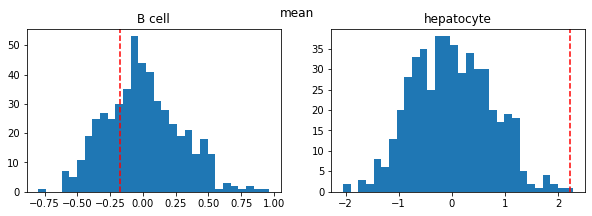

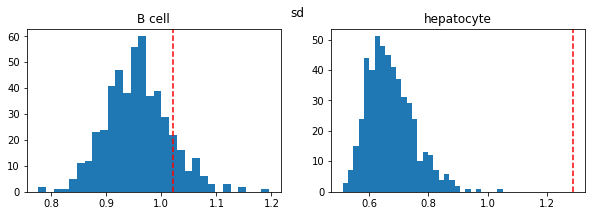

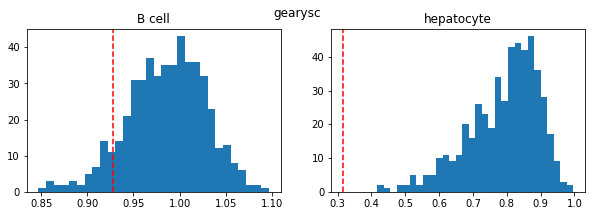

In [24]:
ctrl_zsc = pd.read_csv(f"out/celltype_hetero/{trait}.ctrl_zsc.gz", sep='\t', index_col=0)
trait_col = "trait"
ctrl_cols = [col for col in ctrl_zsc.columns if col.startswith("ctrl_")]

tissue_index = SCORE_ADATA.obs.index[SCORE_ADATA.obs.tissue == tissue]
tissue_ctrl_zsc = ctrl_zsc.loc[tissue_index, :]

zsc_dict = dict()
zsc_dict[trait_col] = tissue_ctrl_zsc[trait_col]
for col in ctrl_cols:
    zsc_dict[col] = tissue_ctrl_zsc[col]
    
zsc_index = tissue_index
trs_stats = util.calculate_trs_stats(zsc_dict=zsc_dict, zsc_index=zsc_index, 
                                stats_dict = {"mean": np.mean, "sd": np.std, "gearysc": None},
                                adata=PLOT_ADATA_DICT[tissue], stratify_by="cell_ontology_class")

ct_list = ["B cell", "hepatocyte"]
for name in ["mean", "sd", "gearysc"]:
    plt.figure(figsize=(10, 3))
    for ct_i, ct in enumerate(ct_list):
        plt.subplot(1, len(ct_list), ct_i + 1)
        plt.hist(trs_stats[name].loc[ct, ctrl_cols], 30)
        plt.axvline(trs_stats[name].loc[ct, trait_col], ls="--", color="red")
        plt.title(ct)
    plt.suptitle(name)
    plt.show()

# Comparing different ways of computing the score
1. Three procedures are all different norm / 2-step seems to be quite similar.
2. Raw seems to be quite different from norm / 2-step.

Next we perform the scan between trait - celltype pairs using the norm for simplicity, we will use statistics mean / sd / Geary's C statistics to rank trait - celltype pair to provide a ranking of interestingness.

In [5]:
tissue_list = ['Aorta', 'BAT', 'Bladder', 'Brain_Myeloid', 'Brain_Non-Myeloid',
                'Diaphragm', 'GAT', 'Heart', 'Kidney', 'Large_Intestine',
                'Limb_Muscle', 'Liver', 'Lung', 'MAT', 'Mammary_Gland', 'Marrow', 
                'Pancreas', 'SCAT', 'Skin', 'Spleen', 'Thymus', 'Tongue', 'Trachea']
trait_list = ['PASS_Schizophrenia_Ruderfer2018',
              'PASS_BipolarDisorder_Ruderfer2018',
              'PASS_Alzheimers_Jansen2019', 
              'PASS_AdultOnsetAsthma_Ferreira2019',
              'PASS_Coronary_Artery_Disease', 
              'PASS_LargeArteryStroke_Malik2018', 
              'PASS_HDL', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_Lupus', 
              'PASS_FastingGlucose_Manning',
              'PASS_IBD_deLange2017', 
              'PASS_Type_1_Diabetes', 
              'PASS_Type_2_Diabetes']

result_dir = "out/celltype_hetero/group_stats/"

In [13]:
# read all the scores
pval_threshold = 0.002
score_dir = join(SCORE_FILE_DIR, "score.facs.gwas_max_abs_z.top500")
score_df_dict = dict()
for trait in trait_list:
    score_df_dict[trait] = pd.read_csv(join(score_dir, f"{trait}.score.gz"), sep='\t', index_col=0)

# read the group-level statistics
trait_df_dict = dict()

for trait in trait_list:
    trait_df_list = []
    for tissue in tissue_list:
        mc_pval_dict = dict()
        for stats_name in ["mean", "sd", "gearysc"]:
            trs_stats = pd.read_csv(join(result_dir, f"{trait}.{tissue}.{stats_name}.gz"), index_col=0, sep='\t')
            trait_col = "norm_score"
            ctrl_cols = [col for col in trs_stats.columns if col.startswith("ctrl_norm_score_")]
            if stats_name in ["mean", "sd"]:
                mc_pval_dict[stats_name] = ((trs_stats[trait_col].values < trs_stats[ctrl_cols].values.T).sum(axis=0) + 1) / (len(ctrl_cols) + 1)
            elif stats_name in ["gearysc"]:
                mc_pval_dict[stats_name] = ((trs_stats[trait_col].values > trs_stats[ctrl_cols].values.T).sum(axis=0) + 1) / (len(ctrl_cols) + 1)
        mc_pval_df = pd.DataFrame(mc_pval_dict, index=tissue + '.' + trs_stats.index)
        trait_df_list.append(mc_pval_df)
    trait_df = pd.concat(trait_df_list)
    trait_df_dict[trait] = trait_df

# construct the dict for plotting
plot_dict = dict()
# tissue -> (trait, ct)
for trait in trait_list:
    trait_df = trait_df_dict[trait]
    tissue_ct_list = trait_df[trait_df["gearysc"] < pval_threshold].index.values
    for tissue_ct in tissue_ct_list:
        tissue, ct = tissue_ct.split('.')
        ct_index = PLOT_ADATA_DICT[tissue].obs.index[(PLOT_ADATA_DICT[tissue].obs.cell_ontology_class == ct)]
        if sum(score_df_dict[trait].loc[ct_index, 'zscore'] > 3.) >= 10:
            plot_dict.setdefault(tissue, dict()).setdefault(trait, []).append(ct)
        

Brain_Non-Myeloid


/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


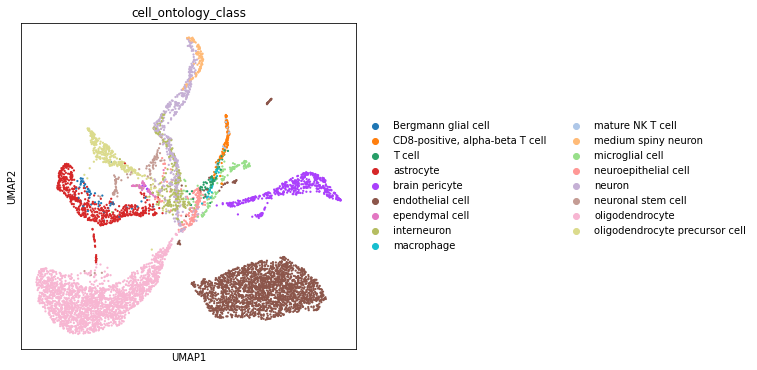

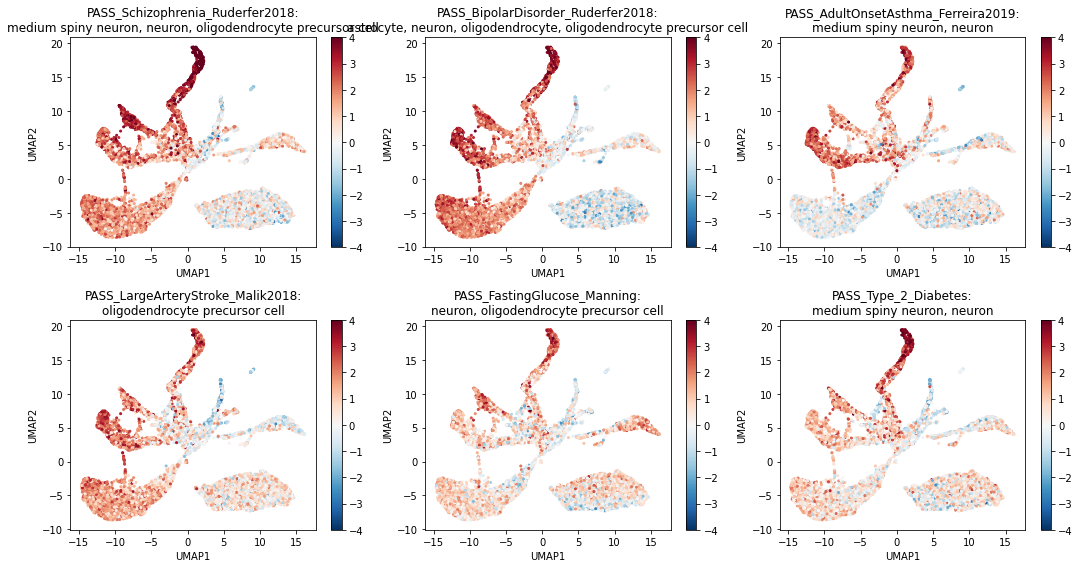

Marrow


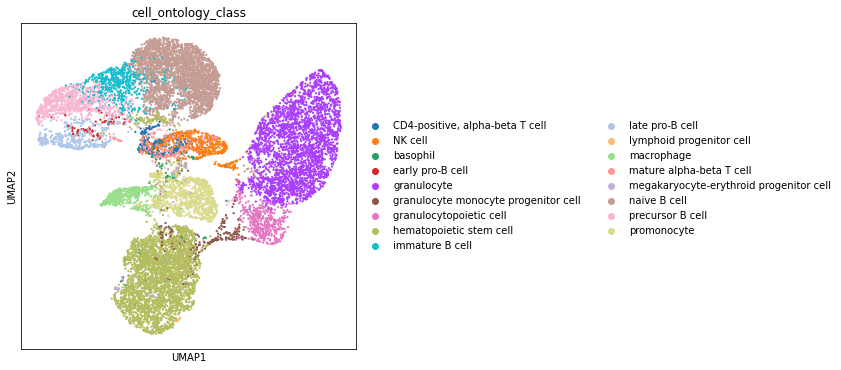

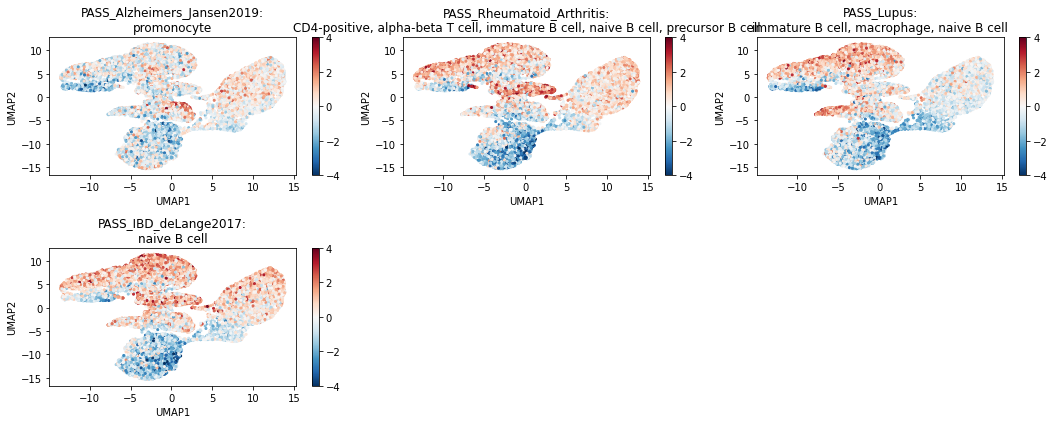

Heart


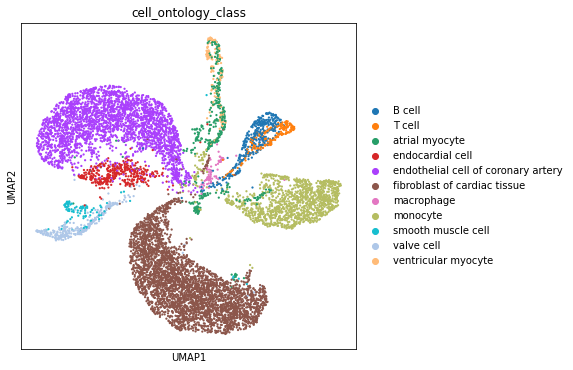

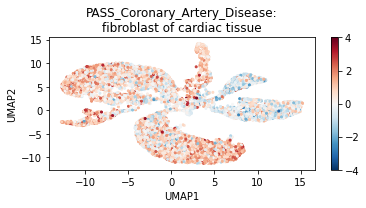

Lung


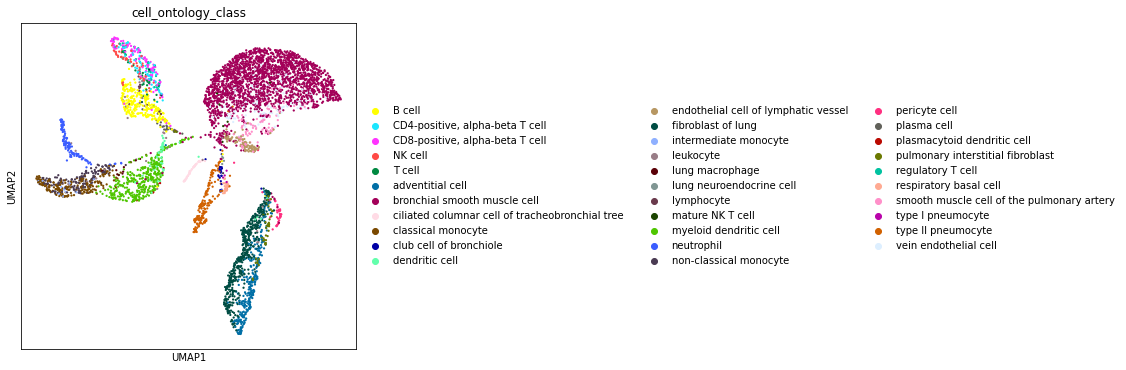

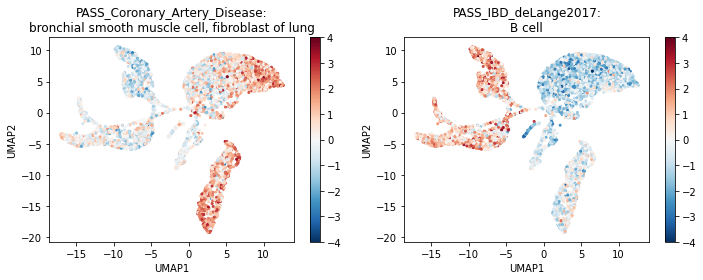

Liver


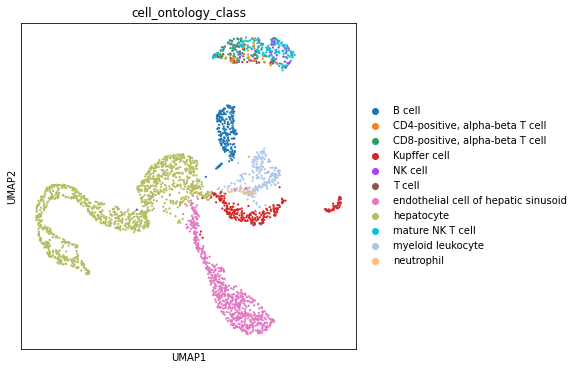

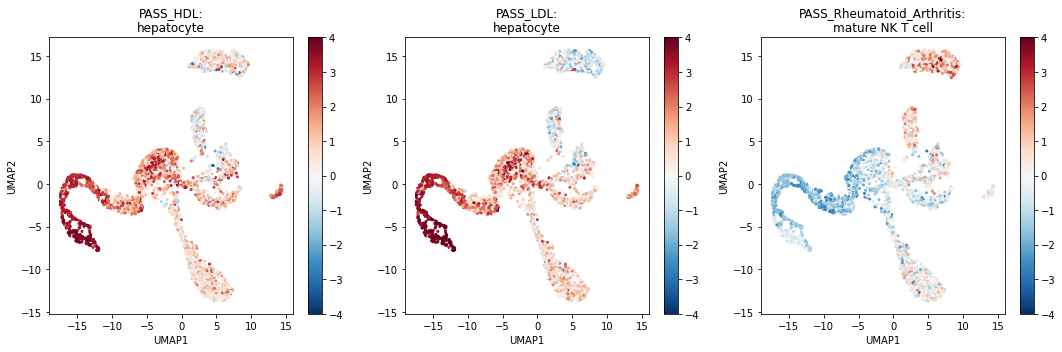

Brain_Myeloid


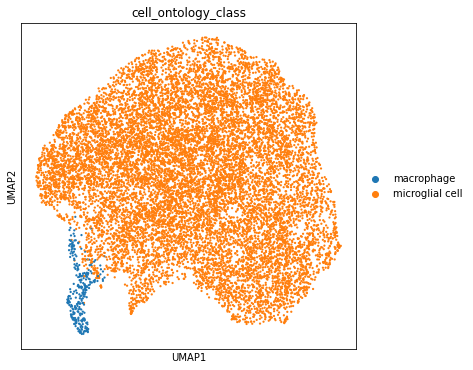

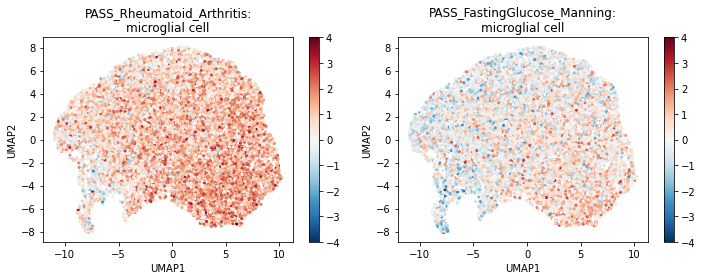

GAT


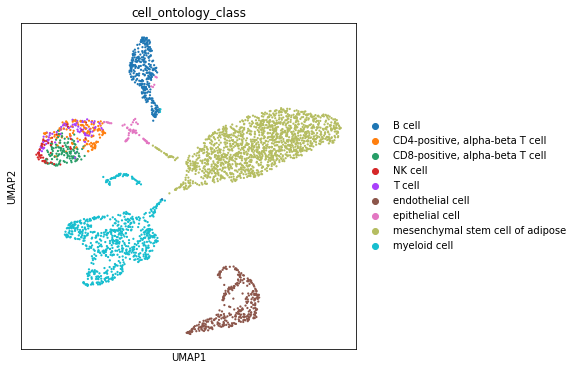

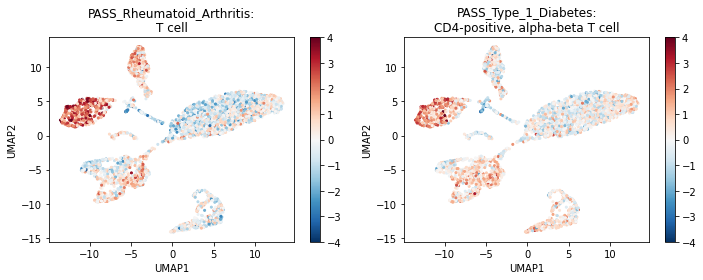

MAT


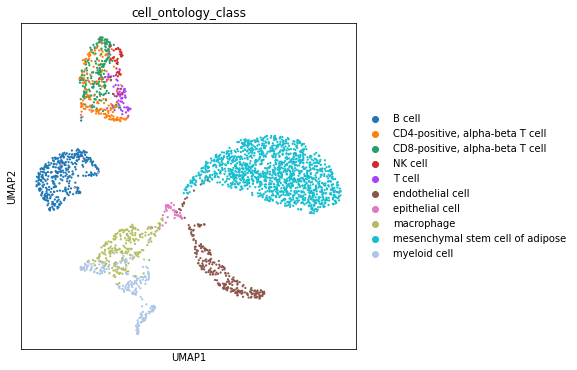

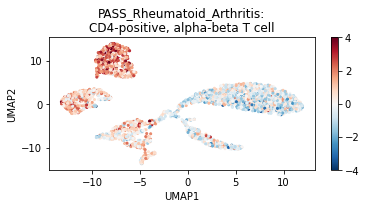

Thymus


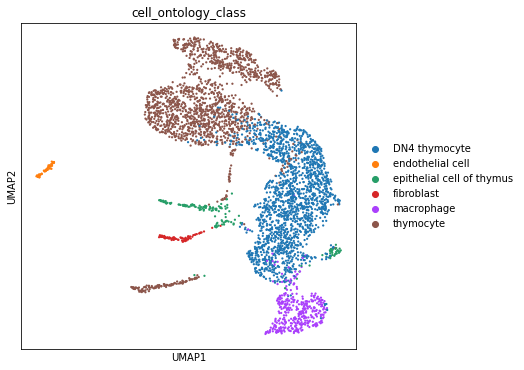

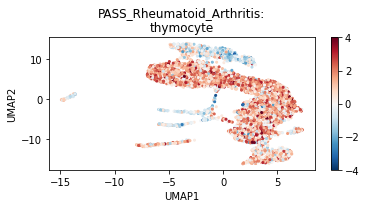

Trachea


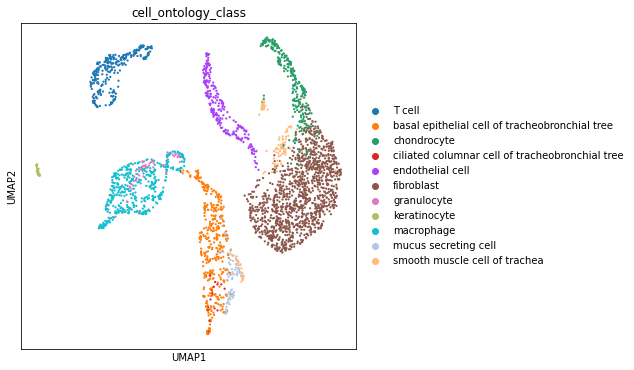

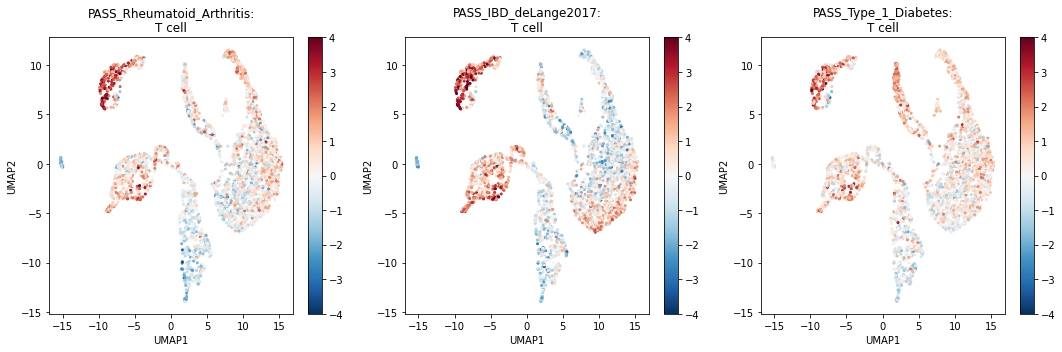

Spleen


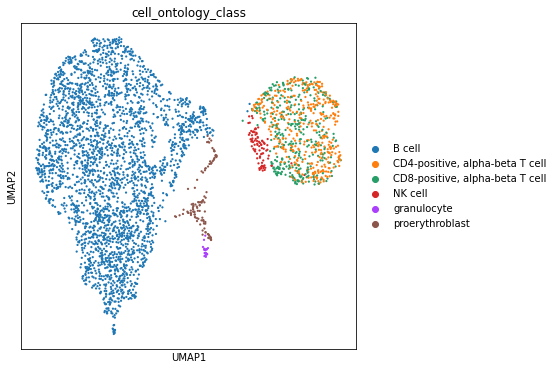

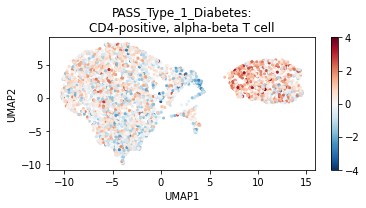

In [14]:
for tissue in plot_dict:
    print(tissue)
    plot_adata = PLOT_ADATA_DICT[tissue]
    tissue_zsc_dict = dict()
    
    for trait in plot_dict[tissue]:
        title = f"{trait}:\n{', '.join(plot_dict[tissue][trait])}"
        tissue_zsc_dict[title] = score_df_dict[trait]["zscore"].reindex(plot_adata.obs.index).values
    score_index = plot_adata.obs.index
    util.plot_score_umap(tissue_zsc_dict, score_index, plot_adata, n_col=3)